In [11]:
import caffe

from caffe import layers as L, params as P, to_proto

from caffe.proto import caffe_pb2

from caffe.coord_map import crop

import copy
from nbfinder import NotebookFinder
import sys
sys.meta_path.append(NotebookFinder())
from layer_util import *
from network_defs import *
import numpy as np
import h5py

In [2]:
pstr, fn, n= make_netcdf_network()

In [3]:
if __name__ == "__main__":
    #fn = "/project/projectdirs/dasrepo/gordon_bell/deep_learning/networks/climate/2d_semi_sup/sm_sq_2d_16.prototxt"
    net=caffe.Net(fn,caffe.TRAIN)

    a =net.forward()

    net.backward()

In [20]:
lbl =net.blobs["label"].data

In [21]:
b =net.blobs['data'].data

In [22]:
b.shape

(4, 16, 768, 1152)

In [8]:
from matplotlib import pyplot as plt

In [9]:
%matplotlib inline

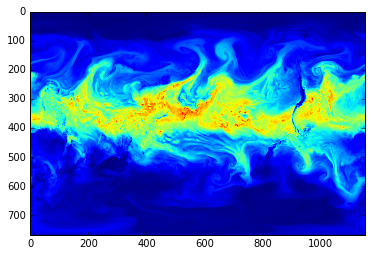

In [10]:
plt.imshow(b[0][6])